# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter

from torch.utils.data.sampler import WeightedRandomSampler

import pandas as pd

from matplotlib import colors, pyplot as plt

from torchvision.utils import save_image
import math
import random
# %matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import telegram_send

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
TRAIN_DIR = Path('journey-springfield/train/') 
TEST_DIR = Path('journey-springfield/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [5]:
len(train_val_files)

20933

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        augment = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            # transforms.CenterCrop(175),
            # transforms.RandomRotation(degrees=(-10, 10)),
            # transforms.RandomPerspective(distortion_scale=0.1, p=0.1),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform(x)
            return x
        else:
            x = augment(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

In [9]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [11]:
train_val_labels = [path.parent.name for path in train_val_files]
data = get_count(train_val_labels)

**Количество объектов некоторых классов слишком мало для обучения и их точного предсказания. При помощи аугментации доведем их число до 1500 объектов.**

In [12]:
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

In [13]:
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
fat_tony,27,1473,55
gil,27,1473,55
otto_mann,32,1468,46
sideshow_mel,40,1460,37
agnes_skinner,42,1458,35


In [14]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [15]:
for image_path in train_val_files:
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    
    if data.loc[character]['to_add'] <= 0:
        continue
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

In [16]:
# TRAIN_DIR = Path('journey-springfield/train/') 
# TEST_DIR = Path('journey-springfield/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
len(train_val_files)

63746

In [18]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

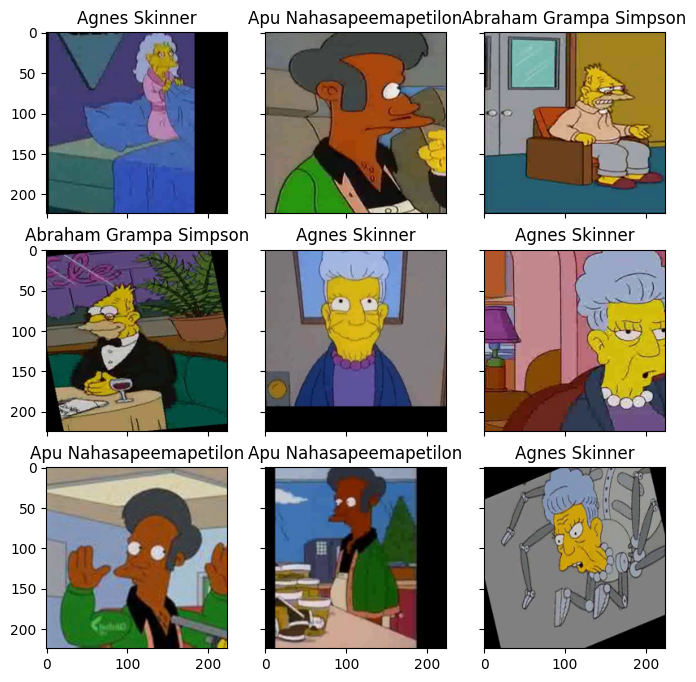

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети


In [21]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [24]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    
    # class_count = Counter(train_dataset.label_encoder.transform(train_dataset.labels))
    # class_weights = {i: 1/c for i, c in class_count.items()}
    # sample_weights = [0] * len(train_dataset)
    # for i, (data, label) in enumerate(tqdm(train_dataset)):
    #     class_weight = class_weights[label]
    #     sample_weights[i] = class_weight

    # N = max(class_count.values()) * len(class_count)  # fit to max
    # train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.01, )
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            try:
                telegram_send.send(messages=[
                    f'{log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc)}'])
            except:
                pass
            
    return history

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
n_classes = len(np.unique(train_val_labels))

**В качестве нейросети возьмем предобученную ResNet18 и будем обучать только самый последний базовый блок и классификатор**

In [27]:
model = models.resnet18(pretrained=True)

num_features= model.fc.in_features

model.fc = nn.Linear(num_features, n_classes)

for name, p in model.named_parameters():
    if name.startswith('layer4.1') or name.startswith('fc'):
        p.requires_grad = True
    else:
        p.requires_grad = False
model = model.to(DEVICE)

In [28]:
# model = models.alexnet(pretrained=True)

# num_features= 1000

# model.fc = nn.Linear(num_features, n_classes)

# for name, p in model.named_parameters():
#     if name.startswith("classifier") or name.startswith("features.10") or name.startswith("fc"):
#         p.requires_grad = True
#     else:
#         p.requires_grad = False
# model = model.to(DEVICE)

In [ ]:
# model = models.googlenet(pretrained=True)

# # num_features= 1000

# model.fc1 = nn.Linear(num_features, 500)
# model.fc2 = nn.Linear(500, n_classes)

# for name, p in model.named_parameters():
#     if name.startswith("fc"):
#         p.requires_grad = True
#     else:
#         p.requires_grad = False
# model = model.to(DEVICE)

In [29]:
for name, p in model.named_parameters():
    print("param name:", name, "requires_grad:", p.requires_grad)

param name: conv1.weight requires_grad: False
param name: bn1.weight requires_grad: False
param name: bn1.bias requires_grad: False
param name: layer1.0.conv1.weight requires_grad: False
param name: layer1.0.bn1.weight requires_grad: False
param name: layer1.0.bn1.bias requires_grad: False
param name: layer1.0.conv2.weight requires_grad: False
param name: layer1.0.bn2.weight requires_grad: False
param name: layer1.0.bn2.bias requires_grad: False
param name: layer1.1.conv1.weight requires_grad: False
param name: layer1.1.bn1.weight requires_grad: False
param name: layer1.1.bn1.bias requires_grad: False
param name: layer1.1.conv2.weight requires_grad: False
param name: layer1.1.bn2.weight requires_grad: False
param name: layer1.1.bn2.bias requires_grad: False
param name: layer2.0.conv1.weight requires_grad: False
param name: layer2.0.bn1.weight requires_grad: False
param name: layer2.0.bn1.bias requires_grad: False
param name: layer2.0.conv2.weight requires_grad: False
param name: layer2

In [30]:
print("we will classify :{}".format(n_classes))
print(model)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

Запустим обучение сети.

In [31]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [32]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=128)
!telegram-send 'Сеть_обучена!'

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.47606495726300296


epoch:   5%|▌         | 1/20 [09:49<3:06:42, 589.61s/it]


Epoch 001 train_loss: 0.4761     val_loss 0.2422 train_acc 0.8797 val_acc 0.9336
loss 0.21905004103665132


epoch:  10%|█         | 2/20 [15:51<2:16:39, 455.52s/it]


Epoch 002 train_loss: 0.2191     val_loss 0.1626 train_acc 0.9398 val_acc 0.9556
loss 0.11974437165030669


epoch:  15%|█▌        | 3/20 [22:11<1:59:22, 421.35s/it]


Epoch 003 train_loss: 0.1197     val_loss 0.1662 train_acc 0.9668 val_acc 0.9551
loss 0.09213818879567995


epoch:  20%|██        | 4/20 [28:33<1:48:11, 405.69s/it]


Epoch 004 train_loss: 0.0921     val_loss 0.1414 train_acc 0.9741 val_acc 0.9652
loss 0.08303679103929514


epoch:  25%|██▌       | 5/20 [34:40<1:37:54, 391.62s/it]


Epoch 005 train_loss: 0.0830     val_loss 0.1554 train_acc 0.9769 val_acc 0.9617
loss 0.05625948811564674


epoch:  30%|███       | 6/20 [40:58<1:30:20, 387.20s/it]


Epoch 006 train_loss: 0.0563     val_loss 0.1824 train_acc 0.9846 val_acc 0.9603
loss 0.05575228645166762


epoch:  35%|███▌      | 7/20 [46:48<1:21:12, 374.79s/it]


Epoch 007 train_loss: 0.0558     val_loss 0.2075 train_acc 0.9840 val_acc 0.9573
loss 0.06358023247909261


epoch:  40%|████      | 8/20 [52:16<1:12:01, 360.13s/it]


Epoch 008 train_loss: 0.0636     val_loss 0.1434 train_acc 0.9835 val_acc 0.9689
loss 0.05135021534037333


epoch:  45%|████▌     | 9/20 [57:45<1:04:12, 350.24s/it]


Epoch 009 train_loss: 0.0514     val_loss 0.1349 train_acc 0.9871 val_acc 0.9723
loss 0.045912744506202266


epoch:  50%|█████     | 10/20 [1:04:14<1:00:21, 362.19s/it]


Epoch 010 train_loss: 0.0459     val_loss 0.1651 train_acc 0.9881 val_acc 0.9666
loss 0.011290950324198863


epoch:  55%|█████▌    | 11/20 [1:09:41<52:44, 351.57s/it]  


Epoch 011 train_loss: 0.0113     val_loss 0.1032 train_acc 0.9972 val_acc 0.9811
loss 0.003987634937270423


epoch:  60%|██████    | 12/20 [1:15:08<45:51, 343.94s/it]


Epoch 012 train_loss: 0.0040     val_loss 0.0998 train_acc 0.9988 val_acc 0.9819
loss 0.002310084421605925


epoch:  65%|██████▌   | 13/20 [1:20:34<39:30, 338.59s/it]


Epoch 013 train_loss: 0.0023     val_loss 0.1038 train_acc 0.9994 val_acc 0.9812
loss 0.0014883892588069823


epoch:  70%|███████   | 14/20 [1:26:01<33:29, 334.91s/it]


Epoch 014 train_loss: 0.0015     val_loss 0.1108 train_acc 0.9997 val_acc 0.9831
loss 0.0010837491418170437


epoch:  75%|███████▌  | 15/20 [1:31:27<27:42, 332.41s/it]


Epoch 015 train_loss: 0.0011     val_loss 0.1082 train_acc 0.9997 val_acc 0.9821
loss 0.0011397908012926222


epoch:  80%|████████  | 16/20 [1:36:53<22:02, 330.58s/it]


Epoch 016 train_loss: 0.0011     val_loss 0.1124 train_acc 0.9998 val_acc 0.9832
loss 0.0006136623989427942


epoch:  85%|████████▌ | 17/20 [1:42:20<16:28, 329.46s/it]


Epoch 017 train_loss: 0.0006     val_loss 0.1138 train_acc 0.9999 val_acc 0.9824
loss 0.00039312027657049806


epoch:  90%|█████████ | 18/20 [1:47:47<10:57, 328.73s/it]


Epoch 018 train_loss: 0.0004     val_loss 0.1146 train_acc 0.9999 val_acc 0.9829
loss 0.00028256504287910785


epoch:  95%|█████████▌| 19/20 [1:53:57<05:41, 341.03s/it]


Epoch 019 train_loss: 0.0003     val_loss 0.1100 train_acc 1.0000 val_acc 0.9836
loss 0.00023186391149169344


epoch: 100%|██████████| 20/20 [2:02:21<00:00, 389.88s/it]


Epoch 020 train_loss: 0.0002     val_loss 0.1137 train_acc 0.9999 val_acc 0.9836


epoch: 100%|██████████| 20/20 [2:02:21<00:00, 367.08s/it]


Построим кривые обучения

In [33]:
loss, acc, val_loss, val_acc = zip(*history)

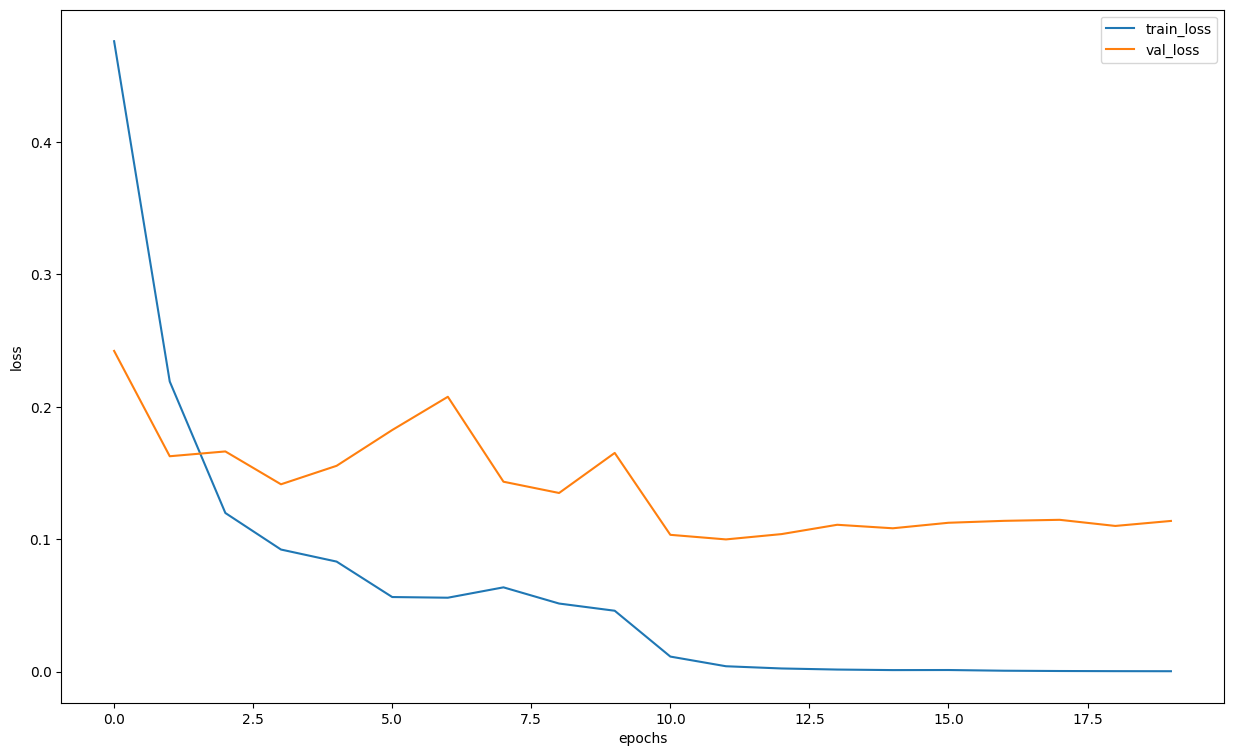

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [37]:
# idxs = list(map(int, np.random.uniform(0,1000, 900)))
idxs = range(990)
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [40]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')


0.9906855439642325

**Перемудрил, но нужная метрика достигнута**

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

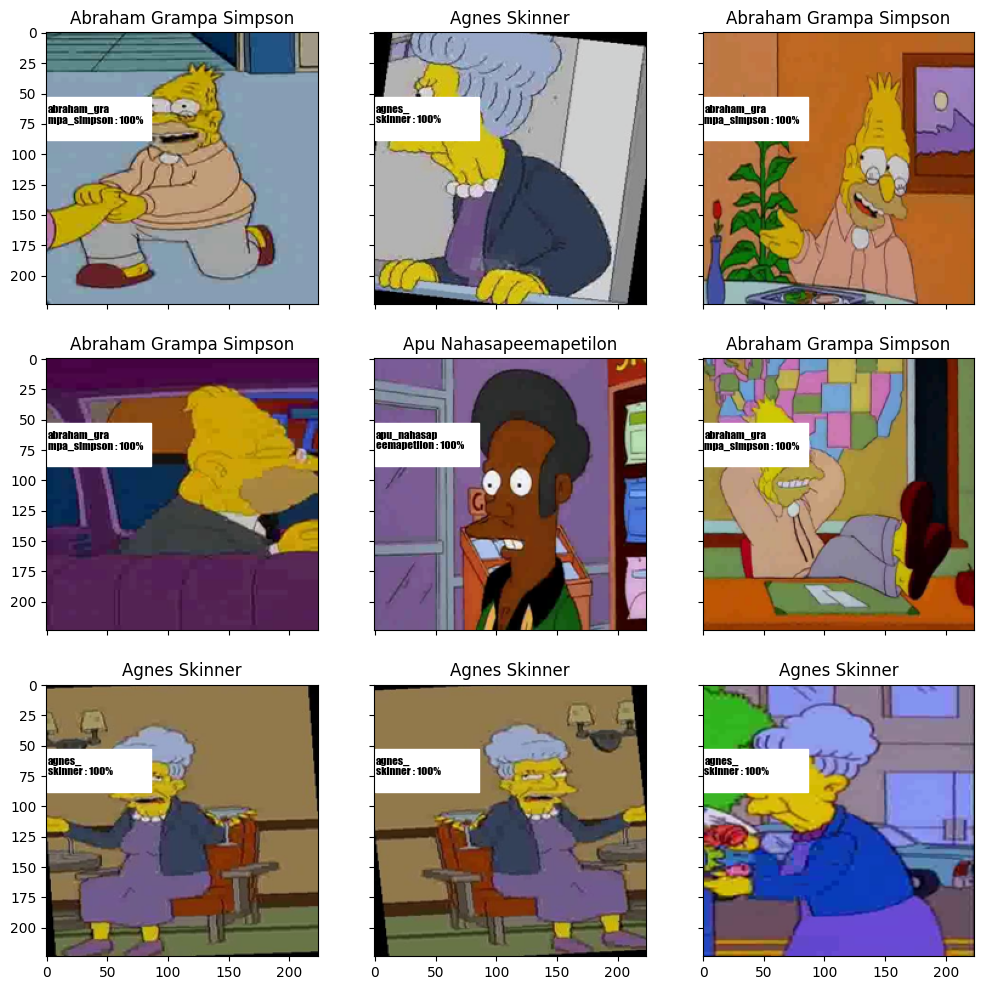

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [45]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [47]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
